In [2]:
using Pkg; Pkg.activate("../")
include("../src/EEGToolkit.jl")
include("../src/ts.jl")
include("../src/eeg.jl")
include("../src/psd.jl")
using Dates
using EDF
using Plots
using FFTW
using DSP
using Statistics
using CSV
using DataFrames



  Activating project at `~/.julia/dev/EEGToolkit`


### Loading data

We will load the EEG from S78 Baseline.

In [3]:
eeg = EEG("wsuedf.edf")
channel = get_channel(eeg, "EEG C3-A2")
signal = channel.x
fs = channel.fs

500

### Comparing with Julia's Welch's method.

On a single segment, our PSD function is  $P(f) := \frac{2|H(f)|^2}{\zeta \sum w_i^2}$ where $\zeta$ is a normalization which defaults to $1$. Frequency resolution obeys the expected relation: $f_s / N$. When using Welch's or Barlett's method, we do

$$
P'(f) := \frac{1}{\zeta KM}\sum_{i=1}^M P_i(f) 
$$

where $M$ the number of segments, $K$ the length of each segment, and $P_i(f)$ is the function $P(f)$ applied to the $i$th segment. Of course, frequency resolution here is $f_s / K$.

Since Julia's Welch's method does *not* use $K$, but normalizes with $f_s$, we need to set $\zeta = \frac{fs}{K}$ to have a match. 

In [4]:
# Compute spectrum
K = fs * 30
my_psd = PSD(signal, fs, K; overlap=0, normalization=(fs/K))
julias_psd = welch_pgram(signal, fs*30, 0; fs = fs, window=hanning)


DSP.Periodograms.Periodogram{Float32, Frequencies{Float64}, Vector{Float32}}(Float32[2817.1438, 2013.488, 909.625, 1046.3265, 1018.4612, 875.7368, 742.2212, 638.51776, 587.2495, 538.97766  …  0.0003426075, 0.00028618288, 0.00028045537, 0.00033599508, 0.0004752856, 0.00043590588, 0.0004012214, 0.0004346571, 0.0005380446, 0.00021056029], [0.0, 0.03333333333333333, 0.06666666666666667, 0.1, 0.13333333333333333, 0.16666666666666666, 0.2, 0.23333333333333334, 0.26666666666666666, 0.3  …  249.7, 249.73333333333332, 249.76666666666665, 249.79999999999998, 249.83333333333334, 249.86666666666667, 249.9, 249.93333333333334, 249.96666666666667, 250.0])

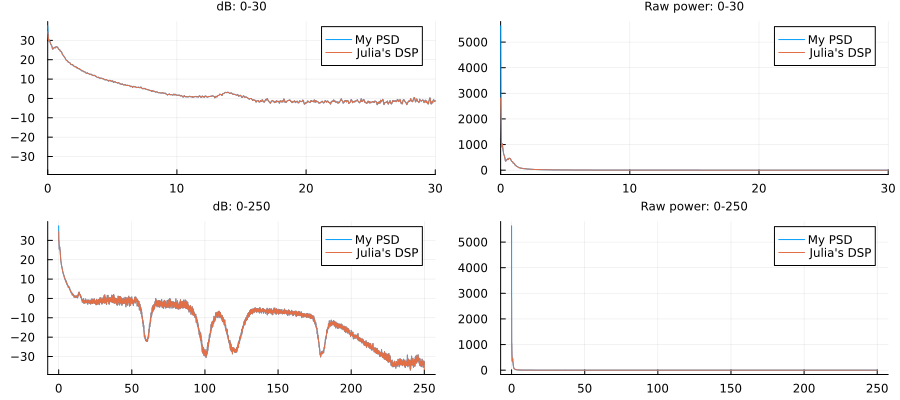

In [4]:
# Set up the plots
p1 = plot(my_psd.freq, pow2db.(my_psd.spectrum), label="My PSD", title="dB: 0-30", titlefontsize=8)
p1 = plot!(julias_psd.freq, pow2db.(julias_psd.power), label="Julia's DSP")
p1 = xlims!(0, 30)
p2 = plot(my_psd.freq, (my_psd.spectrum), label="My PSD", title="Raw power: 0-30", titlefontsize=8)
p2 = plot!(julias_psd.freq, (julias_psd.power), label="Julia's DSP")
p2 = xlims!(0, 30)

p3 = plot(my_psd.freq, pow2db.(my_psd.spectrum), label="My PSD", title="dB: 0-250", titlefontsize=8)
p3 = plot!(julias_psd.freq, pow2db.(julias_psd.power), label="Julia's DSP")
p4 = plot(my_psd.freq, (my_psd.spectrum), label="My PSD", title="Raw power: 0-250", titlefontsize=8)
p4 = plot!(julias_psd.freq, (julias_psd.power), label="Julia's DSP")
plot(p1, p2, p3, p4, layout=(2, 2), size=(900, 400))

It can be observed as well that the total power in the frequency range $[0.4, 8]$ is the same for both methods:

In [5]:
# Find index bounds for the frequency range
lims = (findall(x -> x == 0.4, my_psd.freq)[1], findall(x -> x == 8, my_psd.freq)[1])
# Compute total power in both spectrums
total_power_mypsd = sum(my_psd.spectrum[lims[1]:lims[2]])
total_power_julia = sum(julias_psd.power[lims[1]:lims[2]])
# Test for approximate equality (floating point errors)
isapprox(total_power_mypsd, total_power_julia)

true

## Matching Hans' spectrum

First, let's load some of the data we will use. In particular, let's load the spectrum for the NREM periods computed at WSU.

In [5]:
# Read the data frame
wsu_spectrumnorem_df = CSV.read("spectrumnorem.csv", DataFrame)
wsu_spectrumnorem_df[1:10, :]

Row,frequency,grandmeanpower,nremminutes
,Float64,Float64,Float64
1,0.4,74.5748,374.5
2,0.6,99.4555,374.5
3,0.8,97.2351,374.5
4,1.0,70.9963,374.5
5,1.2,45.0703,374.5
6,1.4,29.0293,374.5
7,1.6,20.2897,374.5
8,1.8,15.2356,374.5
9,2.0,11.9997,374.5


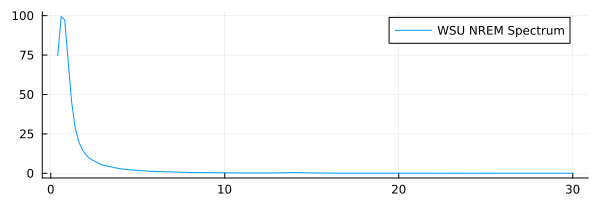

In [6]:
# Extract frequency theand spectrum
frequency, wsu_nrem_spectrum = wsu_spectrumnorem_df[!, "frequency"],  wsu_spectrumnorem_df[!, "grandmeanpower"]
plot(frequency, wsu_nrem_spectrum, label="WSU NREM Spectrum", size=(600, 200))

To be sure of the way in which the above NREM spectrum was computed, let us try to replicate it using the spectrum of the epochs, as computed by WSU.

In [7]:
# Read the
wsu_epochs_spectrum = CSV.read("78Spectrum.csv", DataFrame)
wsu_epochs_spectrum



Row,epoch,frequency,meanpower,ourMeanPower,logpower,1
,Int64,String7,String15,Float64?,String31,Int64
1,38,"0,4","51,04857612",51.0471,"1,707983633",1
2,38,"0,6","30,45487857",20.2482,"1,483656872",1
3,38,"0,8","25,00126896",27.7902,"1,397962052",1
4,38,1,"10,28750407",9.53426,"1,01231002",1
5,38,"1,2","12,34423862",13.7275,"1,091464308",1
6,38,"1,4","10,13537784",13.2605,"1,005839943",1
7,38,"1,6","5,218367094",4.67753,"0,717534627",1
8,38,"1,8","6,592492492",4.51757,"0,8190496439",1
9,38,2,"9,938942707",7.2096,"0,9973401871",1


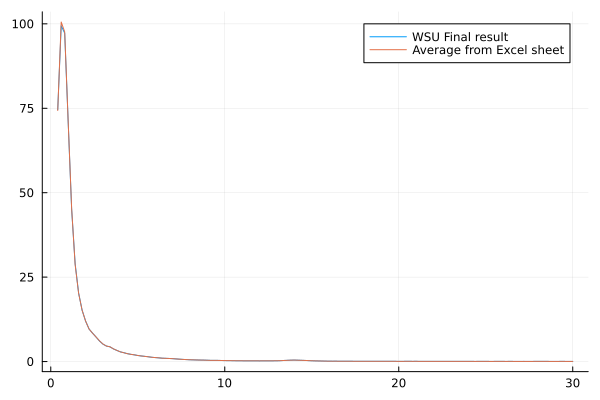

In [8]:
unique_epochs = unique(wsu_epochs_spectrum.epoch)
# Get the mean power of each epoch [[...], ..., [...]]
wsu_spectrums = [wsu_epochs_spectrum.meanpower[149*(i-1)+1:149*i] for i in 1:length(unique_epochs)]
# Convert to float (its str)
wsu_spectrums = [replace.(x, "," => ".") for x in wsu_spectrums]
wsu_spectrums = [parse.(Float64, x) for x in wsu_spectrums]
# Plot
plot(frequency,  wsu_nrem_spectrum , label="WSU Final result")
plot!(frequency, mean( wsu_spectrums ), label="Average from Excel sheet")


This perfect match ensures that the NREM spectrum was indeed computed by averaging the spectrum of the epochs. Since we have access to the spectrum of these epochs, via $\text{wsu\_spectrums}[i]$ for the $i$th epoch, we have everything we need to compare.

Let us now filter the signal and then extract the NREM epochs. I have verified through comparison with Dr. Goldschmied's excel sheet that the epochs we are extracting are the ones WSU used to compute the spectrum.

In [12]:
function apply_filters(signal)
    filtSignal = filt(digitalfilter(Lowpass(70, fs=fs), Butterworth(4)), signal )
    filtSignal = filt(digitalfilter(Highpass(0.3, fs=fs), Butterworth(4)), filtSignal )
    filtSignal = filt(digitalfilter(Bandstop(60, 120, fs=fs), Butterworth(4)), filtSignal )
    return filtSignal
end


function apply_analog_filters(signal)
    # Define Butterworth filters as analog filters
    lowpass_filt = analogfilter(Lowpass(70), Butterworth(4))
    highpass_filt = analogfilter(Highpass(0.3), Butterworth(4))
    notch_filt = analogfilter(Bandstop(60, 120), Butterworth(4))

    # Apply filters sequentially
    filtSignal = filt(lowpass_filt, signal, fs)
    filtSignal = filt(highpass_filt, filtSignal, fs)
    filtSignal = filt(notch_filt, filtSignal, fs)

    return filtSignal
end

analogfiltSignal=signal#apply_analog_filters(signal)
digFiltSignal = apply_filters(signal)
# Get staging
staging = CSV.read("staging.csv", DataFrame)
# Define filter function to keep out everything but N2 and N3.
f(x) = x != "REM" && x!= "WK" && x != "N1" && x != "NS"
# Extract NREM epochs.
nrem_epochs = staging[f.(staging.Stage), " Epoch"]
nrem = segment(digFiltSignal, 30*fs; symmetric=true)[nrem_epochs[1:length(nrem_epochs)-1]]
analogNrem = segment(analogfiltSignal, 30*fs; symmetric=true)[nrem_epochs[1:length(nrem_epochs)-1]]

print("Number of NREM epochs: ", length(nrem))

Number of NREM epochs: 749

In [7]:
digFiltSignal == analogfiltSignal

false

Now, we need to keep in mind that at WSU the analysis is done as follows:

- Each epoch is split in $5$-sec subepochs, and the spectrum of these sub-epochs is computed, obtaining $6$ spectrums: $P_1, \ldots, P_6$
- The spectrum of the epoch is defined as the mean spectrum of its subepochs: $\frac{1}{6}\sum P_i$.
- The total spectrum of the period is the mean spectrum of the epochs in that period.

So let's write a function that uses our power spectrum analysis algorithm in this way. It will not return the period mean, but a list with the spectrum of each epoch. This will allow us to compare our results with those of WSU in greater detail.

In [13]:


function analyze(epochs, fs; segment_length=fs*5)
    spectrums = []
    psd = Nothing
    for epoch in epochs 
        subepochs = segment(epoch, segment_length; symmetric=true)
        psd = PSD(subepochs, fs; normalization=1, window_function=hanning)
        push!(spectrums, psd.spectrum)
    end
    return psd.freq, spectrums
end

F, S = analyze(nrem, fs)
F, S = F[3:151], [x[3:151] for x in S]

anF, anS = analyze(analogNrem, fs)
anF, anS = anF[3:151], [x[3:151] for x in anS]

print("Computed spectrum of ", length(S), " epochs. Spectrum length: ", length(S[1]), ". Frequency resolution: ", F[2] - F[1])

Computed spectrum of 749 epochs. Spectrum length: 149. Frequency resolution: 0.19999999999999996

Now let's compare the total NREM spectrum with that of WSU:

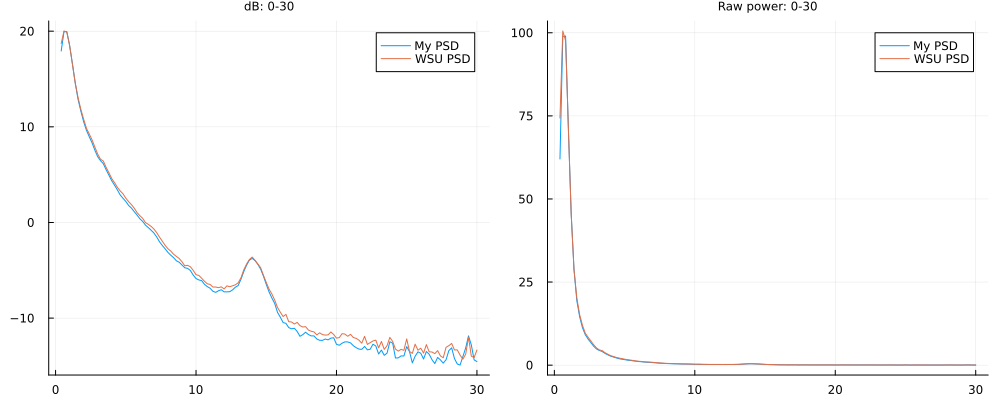

In [40]:
p1 = plot(F,  pow2db.( mean(S) ) , label="My PSD", title="dB: 0-30", titlefontsize=8)
#p1 = plot!(F,  pow2db.( mean(anS) ) , label="My PSD (no filter)", title="dB: 0-30", titlefontsize=8)
p1 = plot!(frequency,  pow2db.( mean(wsu_spectrums) ), label="WSU PSD")

p2 = plot(F,  ( mean(S) ) , label="My PSD", title="Raw power: 0-30", titlefontsize=8)
p2 = plot!(frequency,  ( mean(wsu_spectrums) ), label="WSU PSD")

plot(p1, p2, size=(1000, 400))


So here's where we stand with regards to the NREM spectrum: a decent, yet not perfect match... Let us take a closer look at the epoch by epoch spectrum.

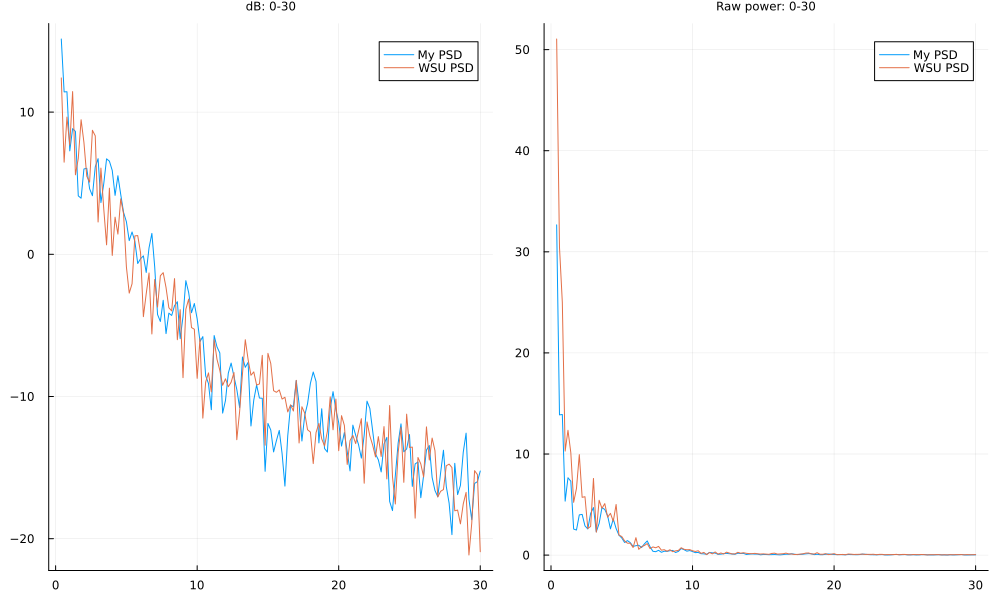

In [17]:
function compare_epoch_spectrum(epoch)
    p1 = plot(F,  pow2db.( S[epoch] ) , label="My PSD", title="dB: 0-30", titlefontsize=8)
    p1 = plot!(frequency,  pow2db.( wsu_spectrums[epoch] ), label="WSU PSD")

    p2 = plot(F,  ( S[epoch] ) , label="My PSD", title="Raw power: 0-30", titlefontsize=8)
    p2 = plot!(frequency,  ( wsu_spectrums[epoch] ), label="WSU PSD")
    
    plot(p1, p2, size=(1000, 600))
end

compare_epoch_spectrum(1)


This discrepancy is strange. Our final result is so close to WSU's that we would expect a greater match in the specific epochs. Let's see if perhaps some subepochs were artifact rejected.

In [10]:
A = [sum(wsu_spectrums[i][1:19]) for i in 1:length(wsu_spectrums)]
B = [sum(S[i][1:19]) for i in 1:length(S)]
C = [sum(anS[i][1:19]) for i in 1:length(S)]
# Fill last epoch with arbitrary value to make hcat work.
push!(B, A[end] - 5.6942)
push!(C, A[end] - 5.6942)
hcat(A, B, C)

750×3 Matrix{Float64}:
 206.722   126.636   151.244
 122.266   120.518   138.099
 108.052    87.3434  100.087
 103.269    85.6123   83.658
 235.998   383.295   381.969
  95.3307   93.1282  116.914
 370.445   387.188   382.302
 267.62    399.289   395.66
 150.538   116.14    109.157
 416.361   218.069   252.464
 223.538   151.255   155.701
 290.942   202.932   195.862
 446.658   419.79    445.586
   ⋮                 
 333.074   592.366   566.832
  80.3789   59.855    63.1235
  96.7984   76.3174   79.727
 194.375    93.6121   92.5847
  90.1444   81.5349   83.7245
 182.687   217.043   197.502
 127.609    88.8748   95.6783
 172.028   105.07    148.701
 112.156    84.7866  110.738
 440.422   409.228   304.613
 624.344   625.542   845.047
 176.97    171.275   171.275

In [42]:
hcat(S, wsu_spectrums)

LoadError: DimensionMismatch: vectors must have same lengths

In [49]:
hcat([hcat(S[i], wsu_spectrums[i]) for i in 1:749]...)

149×1498 Matrix{Float64}:
 32.666      51.0486     11.0084    17.3077    …   78.7745      116.12
 13.8693     30.4549     10.8801    19.3691       116.542        97.2315
 13.9068     25.0013     10.2934     6.70198       96.9955      109.585
  5.33667    10.2875      5.24245    7.2592        93.1148      110.217
  7.65121    12.3442      6.65954    9.64196      100.197        77.9552
  7.3071     10.1354      8.96812    4.45876   …   48.6875       30.3286
  2.57554     5.21837     6.4954     7.79422       22.6906       25.9159
  2.47964     6.59249     4.79654    5.18984        5.06339       6.87092
  3.98131     9.93894     2.77209    3.7867         5.89929       4.55318
  4.02574     5.71601     3.99643    4.32044        5.81937       6.59289
  2.8926      5.77513     4.25286    2.54021   …    2.78715       3.29913
  2.58266     2.63702     7.32885    6.06416        6.90179       6.24446
  4.11845     2.83124    10.6805     8.76044        4.71144       3.42738
  ⋮                    

In [50]:
hcat(mean(S), mean(wsu_spectrums))

149×2 Matrix{Float64}:
 62.0337      74.3561
 98.9176     100.554
 99.024       97.6258
 70.8701      71.0851
 45.4901      45.2615
 28.7348      28.7105
 19.3981      20.2315
 14.5836      15.2093
 11.2869      12.0002
  9.18472      9.63452
  7.86542      8.40247
  6.79072      7.28548
  5.68423      6.12853
  ⋮          
  0.0366737    0.0494604
  0.0457259    0.0515307
  0.0488858    0.0543743
  0.037762     0.0464347
  0.0331534    0.0465491
  0.0323103    0.0410257
  0.0396463    0.0372487
  0.0487905    0.0419713
  0.0652015    0.0633868
  0.0524821    0.0400096
  0.0365689    0.0387076
  0.0351358    0.0463825

In [70]:
using DelimitedFiles
writedlm("WSU_epoch_by_epoch.csv",  hcat(frequency, wsu_spectrums[1:749]...), ',')
writedlm("WSU_aggregated.csv",  mean(wsu_spectrums[1:749]), ',')
writedlm("UPenn_aggregated.csv",  mean(S), ',')
writedlm("UPenn_epoch_by_epoch.csv",  hcat(frequency, S...), ',')
writedlm("Record_epoch_by_epoch.csv", hcat(nrem...), ',')

In [64]:
hcat(frequency, S...)

149×750 Matrix{Float64}:
  0.4  32.666      11.0084    8.7571     …  86.6119       78.7745
  0.6  13.8693     10.8801    5.91639       67.9279      116.542
  0.8  13.9068     10.2934    5.27318       59.6925       96.9955
  1.0   5.33667     5.24245   4.36564       70.6747       93.1148
  1.2   7.65121     6.65954   7.45676       65.2509      100.197
  1.4   7.3071      8.96812   4.54417    …  20.014        48.6875
  1.6   2.57554     6.4954    2.75454        8.03574      22.6906
  1.8   2.47964     4.79654   6.13956        4.89173       5.06339
  2.0   3.98131     2.77209   6.29502        3.24425       5.89929
  2.2   4.02574     3.99643   3.83079        1.65631       5.81937
  2.4   2.8926      4.25286   5.86588    …   2.44636       2.78715
  2.6   2.58266     7.32885   7.05299        3.03829       6.90179
  2.8   4.11845    10.6805    6.55227        2.87605       4.71144
  ⋮                                      ⋱               
 27.8   0.0177869   0.310128  0.0393304      0.0220432 

In [72]:
hcat(mean(S), mean(wsu_spectrums[1:749]))

149×2 Matrix{Float64}:
 62.0337      74.4184
 98.9176     100.662
 99.024       97.7248
 70.8701      71.1414
 45.4901      45.2906
 28.7348      28.7305
 19.3981      20.2466
 14.5836      15.2256
 11.2869      12.0112
  9.18472      9.64112
  7.86542      8.40823
  6.79072      7.29188
  5.68423      6.13503
  ⋮          
  0.0366737    0.0495082
  0.0457259    0.0515738
  0.0488858    0.0544219
  0.037762     0.0464829
  0.0331534    0.0465902
  0.0323103    0.0410495
  0.0396463    0.0372863
  0.0487905    0.0420115
  0.0652015    0.0634618
  0.0524821    0.0400458
  0.0365689    0.0387484
  0.0351358    0.0464291

In [67]:
hcat(nrem...)

15000×749 Matrix{Float64}:
 12.8564    -0.107936  -25.6664  18.8665   …    1.1675   -13.5853     9.68919
 12.8402     1.01018   -24.1722  18.9314        2.37435  -13.8539    10.8169
 13.3123     1.92857   -22.7705  18.6576        3.93134  -13.7455    11.5128
 14.2762     2.68944   -21.7271  17.8957        5.54362  -13.1101    11.5777
 15.654      3.27944   -21.3853  16.6092        6.90793  -11.927     10.9467
 17.3387     3.6747    -22.0264  14.8986   …    7.73637  -10.3028     9.77292
 19.0147     4.02156   -23.0807  13.0052        7.96176   -8.46605    8.36869
 20.2629     4.55529   -23.7173  11.207         7.77324   -6.66868    7.07659
 20.8579     5.34212   -23.7398   9.67256       7.3602    -5.09281    6.18346
 20.7438     6.27477   -22.9444   8.45293       6.87267   -3.81873    5.86237
 19.9211     7.26363   -20.9991   7.53951  …    6.53783   -2.81425    6.08207
 18.5722     8.17392   -18.4302   6.81439       6.49708   -1.99279    6.59337
 17.0285     8.72845   -16.2477   6.06673